In [1]:
#imports the libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the total dates recorded in the data set.
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [10]:
# Find the most recent date.
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f" Latest: {latestdate[0]}")

 Latest: 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(latestdate[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
date_1y_ago = dt.date(latest_date.year -1, latest_date.month, latest_date.day)

# Perform a query to retrieve the data and precipitation scores
query_1y = [Measurement.date,Measurement.prcp]
query_1y = session.query(*query_1y).filter(Measurement.date >= date_1y_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
hawaii_prcp = pd.DataFrame(query_1y, columns=['Date','Precipitation'])
hawaii_prcp = hawaii_prcp.dropna(how='any')

# Sort the dataframe by date
hawaii_prcp = hawaii_prcp.set_index("Date")
hawaii_prcp = hawaii_prcp.sort_values(by="Date", ascending=True)
hawaii_prcp.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


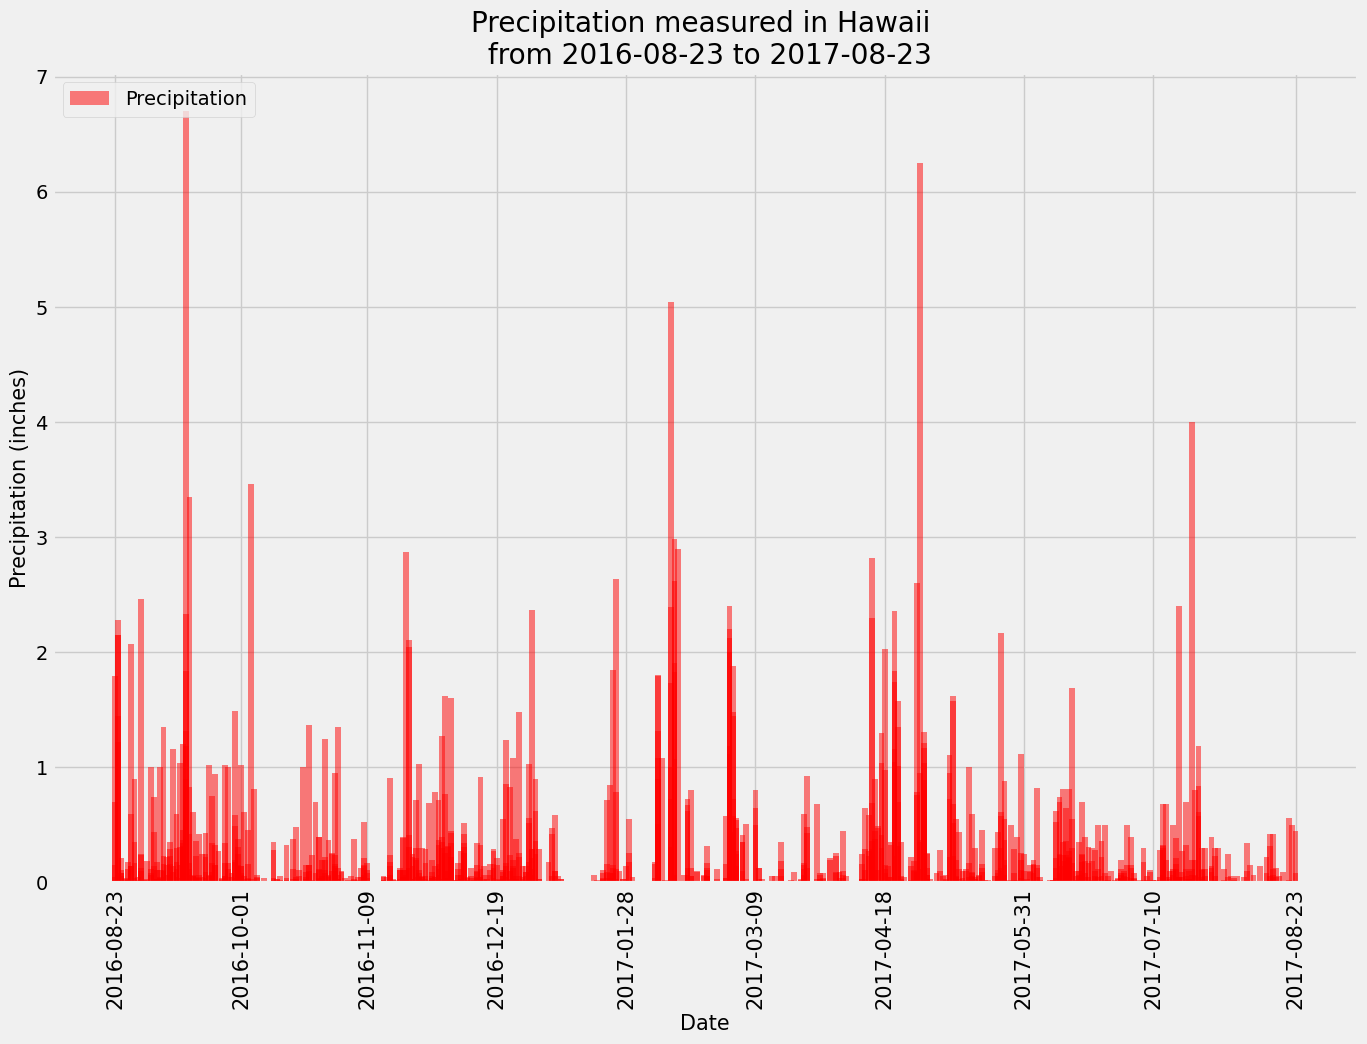

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
x = hawaii_prcp.index
y = hawaii_prcp['Precipitation']
plt.figure(figsize=(15,10))
plt.bar(x,y,width = 1.8 ,color='r', alpha=0.5, align="center",label='Precipitation')
# Set Labels & Title
plt.title(f"Precipitation measured in Hawaii \n from {date_1y_ago} to {latestdate[0]}")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Precipitation (inches)", fontsize=15)
# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18',
        '2017-05-31','2017-07-10','2017-08-23'] 
# Assign xticks
plt.xticks(xloc, rotation='vertical',fontsize=15)
plt.grid(axis='both', linestyle='-',which='major')
# Add legend
plt.legend(loc="upper left")
# Show plot
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
hawaii_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
session.query(Station.id).count()

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activestation = [Station.station, func.count(Measurement.station)]
active_station =session.query(*activestation).filter(Station.station == Measurement.station).\
                            group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station = session.query(*temperature).\
      group_by(Measurement.station).\
      order_by(func.count(Measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

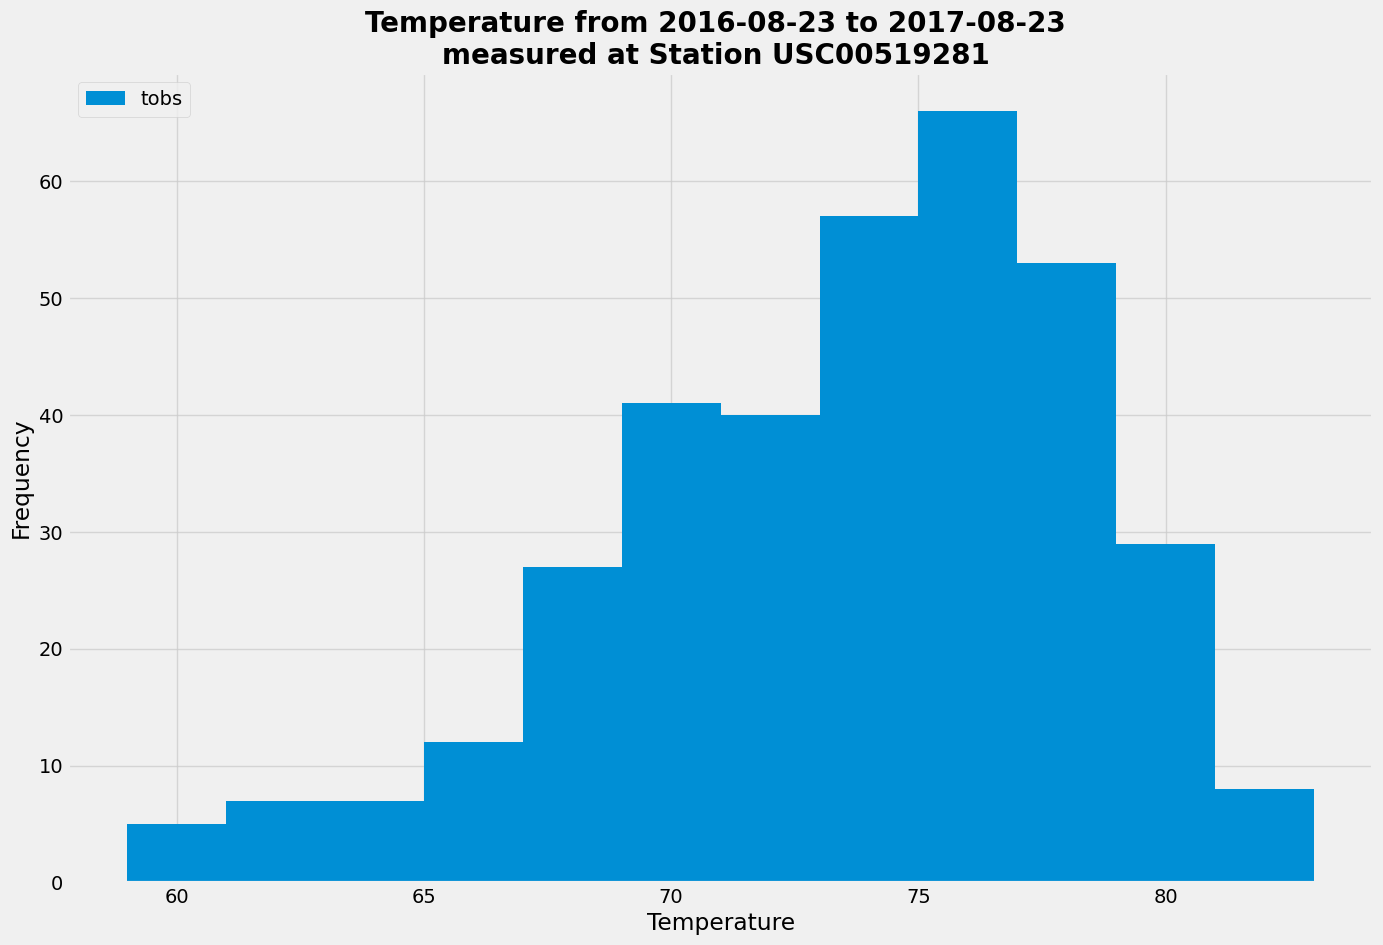

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
temperature_1y = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station[0][0]).\
    filter(Measurement.date >= date_1y_ago).all()
temperature_1y = list(np.ravel(temperature_1y))

sel_data = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
sel_query = session.query(*sel_data).all()
temperature_1y_df = pd.DataFrame(sel_query, columns=['Station','Name','Latitude','Longitude','Elevation'])

#Plot the results as a histogram ; set bins=12
plt.figure(figsize=(15,10))
plt.hist(temperatures, bins=12,rwidth=1,label='tobs')
plt.grid(axis='both', alpha=0.75)
# Set Labels, title & legend
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Temperature from {date_1y_ago} to {latestdate[0]} \nmeasured at Station USC00519281 ",
          fontsize=20, fontweight = 'bold')
plt.legend(loc="upper left")
# Show plot
plt.show()

# Close Session

In [31]:
# Close Session
session.close()